In [2]:
!pip install kagglehub
import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("andrewmvd/bone-marrow-cell-classification")

# Print the path to the dataset
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/bone-marrow-cell-classification/versions/2


In [3]:
!pip install tensorflow pandas matplotlib opencv-python


In [4]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# Dataset path
dataset_path = '/root/.cache/kagglehub/datasets/andrewmvd/bone-marrow-cell-classification/versions/2'


In [7]:
import os
print(os.listdir(dataset_path))


['bone_marrow_cell_dataset', 'abbreviations.csv']


In [8]:
csv_path = os.path.join(dataset_path, "abbreviations.csv")  # Correct CSV file
df = pd.read_csv(csv_path)

# Inspect the content of the CSV
print(df.head())


      Abbreviation;Meaning
0  ABE;Abnormal eosinophil
1             ART;Artefact
2             BAS;Basophil
3                BLA;Blast
4         EBO;Erythroblast


In [9]:
dataset_subfolder = os.path.join(dataset_path, "bone_marrow_cell_dataset")
print(os.listdir(dataset_subfolder))


['BLA', 'LYI', 'NGS', 'MYB', 'PLM', 'MON', 'EBO', 'EOS', 'BAS', 'MMZ', 'FGC', 'HAC', 'PMO', 'NIF', 'LYT', 'ART', 'KSC', 'OTH', 'PEB', 'ABE', 'NGB']


In [10]:
# Directory containing class folders
image_dir = os.path.join(dataset_path, "bone_marrow_cell_dataset")

# Initialize empty lists for image paths and labels
image_paths = []
labels = []

# Loop through each class folder
for folder in os.listdir(image_dir):
    folder_path = os.path.join(image_dir, folder)
    if os.path.isdir(folder_path):  # Check if it's a folder
        for img_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, img_file)
            image_paths.append(image_path)
            labels.append(folder)  # Folder name is the label

# Create a DataFrame
data = pd.DataFrame({'image_path': image_paths, 'label': labels})
print(data.head())


                                          image_path label
0  /root/.cache/kagglehub/datasets/andrewmvd/bone...   BLA
1  /root/.cache/kagglehub/datasets/andrewmvd/bone...   BLA
2  /root/.cache/kagglehub/datasets/andrewmvd/bone...   BLA
3  /root/.cache/kagglehub/datasets/andrewmvd/bone...   BLA
4  /root/.cache/kagglehub/datasets/andrewmvd/bone...   BLA


In [11]:
def load_and_resize_image(image_path, size=(224, 224)):
    try:
        img = cv2.imread(image_path)
        img = cv2.resize(img, size)
        img = img / 255.0  # Normalize
        return img
    except Exception as e:
        print(f"Error loading image: {image_path} - {e}")
        return None

# Apply preprocessing
data['image'] = data['image_path'].apply(load_and_resize_image)
data = data[data['image'].notnull()]  # Drop rows with failed images


Error loading image: /root/.cache/kagglehub/datasets/andrewmvd/bone-marrow-cell-classification/versions/2/bone_marrow_cell_dataset/BLA/6001-7000 - OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error loading image: /root/.cache/kagglehub/datasets/andrewmvd/bone-marrow-cell-classification/versions/2/bone_marrow_cell_dataset/BLA/9001-10000 - OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error loading image: /root/.cache/kagglehub/datasets/andrewmvd/bone-marrow-cell-classification/versions/2/bone_marrow_cell_dataset/BLA/5001-6000 - OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error loading image: /root/.cache/kagglehub/datasets/andrewmvd/bone-marrow-cell-classification/versions/2/bone_marrow_cell_dataset/BLA/7001-8000 - OpenCV(4.10.0) /io

In [12]:
def load_and_resize_image(image_path, size=(224, 224)):
    try:
        # Check if the file is a valid image
        img = cv2.imread(image_path)
        if img is None:  # If the file is not an image
            raise ValueError(f"Invalid image file: {image_path}")
        img = cv2.resize(img, size)
        img = img / 255.0  # Normalize
        return img
    except Exception as e:
        print(f"Error loading image: {image_path} - {e}")
        return None

# Apply preprocessing
data['image'] = data['image_path'].apply(load_and_resize_image)
data = data[data['image'].notnull()]  # Drop rows with failed images


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf

# Encode labels
label_encoder = LabelEncoder()
data['encoded_label'] = label_encoder.fit_transform(data['label'])

# Extract features (images) and labels
X = np.stack(data['image'].values)  # Convert image list to numpy array
y = tf.keras.utils.to_categorical(data['encoded_label'].values)  # One-hot encode labels

# Split into train and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)


Shapes:
X_train: (1044, 224, 224, 3) y_train: (1044, 7)
X_val: (262, 224, 224, 3) y_val: (262, 7)


In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Load prebuilt MobileNetV2
prebuilt_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
prebuilt_model.trainable = False  # Freeze the base model

# Add classification layers
model_prebuilt = Sequential([
    prebuilt_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')  # Output layer
])

# Compile the model
model_prebuilt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_prebuilt = model_prebuilt.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=32)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.3415 - loss: 10.1449 - val_accuracy: 0.6412 - val_loss: 0.9501
Epoch 2/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.5910 - loss: 1.1806 - val_accuracy: 0.6985 - val_loss: 0.8542
Epoch 3/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5989 - loss: 1.0485 - val_accuracy: 0.6947 - val_loss: 0.9368


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define custom CNN
model_custom = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')  # Output layer
])

# Compile the model
model_custom.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_custom = model_custom.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.3147 - loss: 3.0752 - val_accuracy: 0.4695 - val_loss: 1.3646
Epoch 2/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.4698 - loss: 1.3330 - val_accuracy: 0.4962 - val_loss: 1.2109
Epoch 3/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - accuracy: 0.5383 - loss: 1.1383 - val_accuracy: 0.5076 - val_loss: 1.2128


Evaluating Prebuilt Model
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


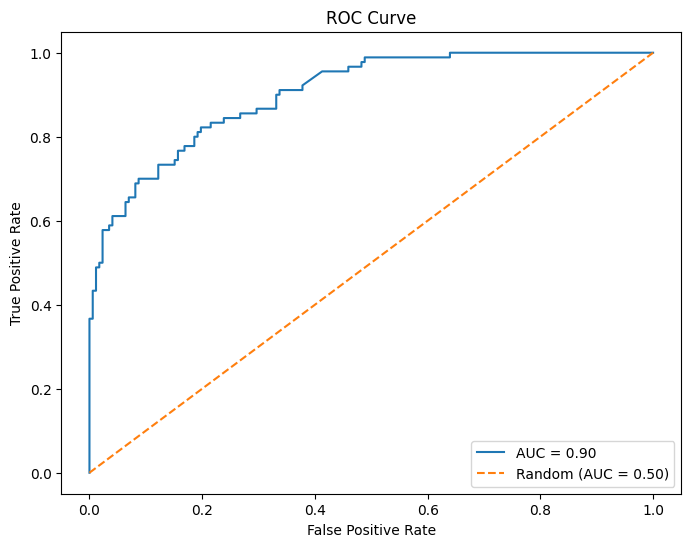

Evaluating Custom Model
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 642ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


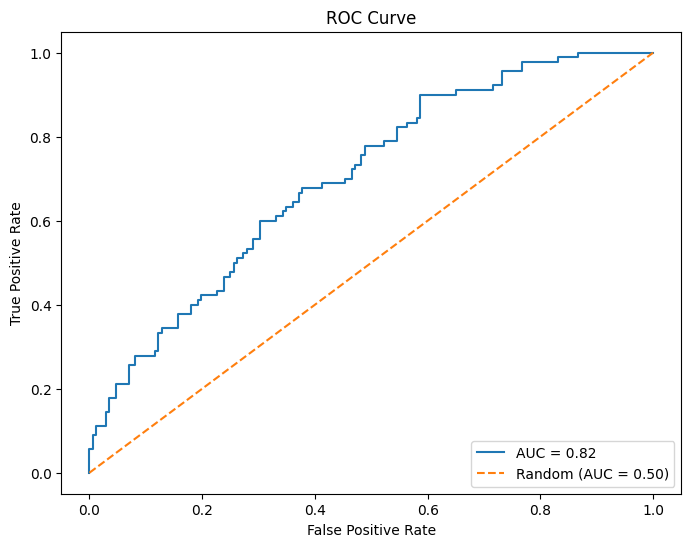


Comparison of Prebuilt and Custom Models:
           Prebuilt Model  Custom Model
accuracy              NaN           NaN
precision        0.694656      0.507634
recall           0.694656      0.507634
f1-score         0.694656      0.507634
AUC-ROC          0.899939      0.815595


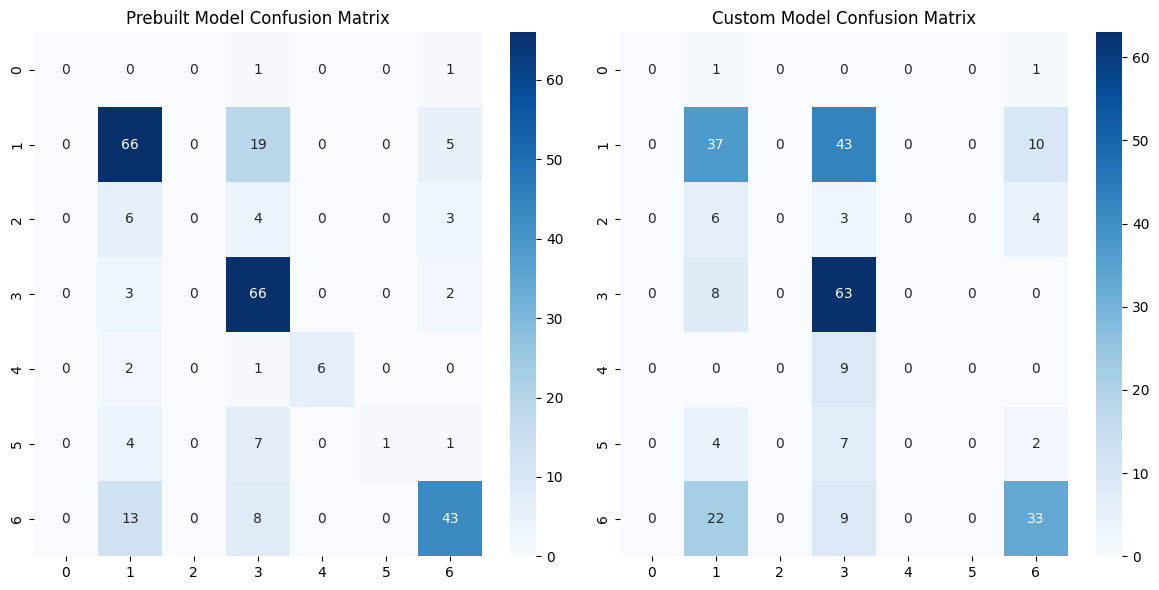

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Define a function to get classification metrics and AUC-ROC
def get_metrics(model, X_val, y_val):
    # Predict probabilities for AUC-ROC
    y_pred_prob = model.predict(X_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_val, axis=1)

    # Calculate Classification Report
    report = classification_report(y_true, y_pred, output_dict=True)

    # Calculate Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate AUC-ROC score (macro-average)
    auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1], pos_label=1)  # For the first class (modify for others)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random (AUC = 0.50)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    return report, cm, auc

# Evaluate Prebuilt Model
print("Evaluating Prebuilt Model")
report_prebuilt, cm_prebuilt, auc_prebuilt = get_metrics(model_prebuilt, X_val, y_val)

# Evaluate Custom Model
print("Evaluating Custom Model")
report_custom, cm_custom, auc_custom = get_metrics(model_custom, X_val, y_val)

# Extract overall metrics for comparison
# Extract Accuracy from the last row of the classification report
accuracy_prebuilt = report_prebuilt['accuracy']
accuracy_custom = report_custom['accuracy']

# Convert classification reports to DataFrames
report_prebuilt_df = pd.DataFrame(report_prebuilt).transpose()
report_custom_df = pd.DataFrame(report_custom).transpose()

# Add Accuracy to the report DataFrames
report_prebuilt_df.loc['accuracy'] = accuracy_prebuilt
report_custom_df.loc['accuracy'] = accuracy_custom

# Combine both models' reports
comparison_df = pd.DataFrame({
    'Prebuilt Model': report_prebuilt_df.loc['accuracy'],
    'Custom Model': report_custom_df.loc['accuracy']
}, index=['accuracy', 'precision', 'recall', 'f1-score'])

# Add AUC-ROC values to comparison table
comparison_df.loc['AUC-ROC'] = [auc_prebuilt, auc_custom]

# Display results
print("\nComparison of Prebuilt and Custom Models:")
print(comparison_df)

# Plot Confusion Matrices for both models
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Prebuilt Confusion Matrix
sns.heatmap(cm_prebuilt, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Prebuilt Model Confusion Matrix')

# Custom Confusion Matrix
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Custom Model Confusion Matrix')

plt.tight_layout()
plt.show()
